In [1]:
# Install required packages (run in the notebook)
%pip install --quiet pandas numpy seaborn matplotlib scikit-learn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('data.csv')
df = data.copy()

# Display first few rows of the dataset
print(df.head())
df.info()
df.describe()


Note: you may need to restart the kernel to use updated packages.
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No 

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [2]:
# a) TotalCharges tiene espacios → convertir a numérico
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

#b) Imputar valores faltantes con la mediana
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

#c)SeniorCitizen (0/1 → categoría)
df["SeniorCitizen"] = df["SeniorCitizen"].map({0: "No", 1: "Yes"})



In [3]:
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
categorical_cols.remove("Churn")
categorical_cols.remove("customerID")  # no aporta
binary_cols = [col for col in categorical_cols 
               if set(df[col].unique()) == {"Yes", "No"}]

for col in binary_cols:
    df[col] = df[col].map({"Yes": 1, "No": 0})



multi_cat_cols = list(set(categorical_cols) - set(binary_cols))

df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)


df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})


from sklearn.preprocessing import StandardScaler

num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])



--------------------------------------Sección de modelado hecha por Jncml0.--------------------------------------

División de los datos (Train/Test)

En esta sección se separa la variable objetivo **Churn** del resto de variables predictoras.Luego se divide el dataset en un conjunto de entrenamiento (70%) y uno de prueba (30%).Esto es importante para evaluar el desempeño real de los modelos sin sesgos.

In [4]:
y = df["Churn"]
X = df.drop(["Churn", "customerID"], axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)


Entrenamiento de los modelos de Machine Learning

Aquí se entrenan tres modelos clásicos para problemas de clasificación:

- Regresión Logística: modelo lineal simple y muy interpretable.
- Árbol de Decisión: modelo basado en reglas.
- Random Forest: conjunto de muchos árboles, generalmente más preciso.

Cada modelo se ajusta usando los datos ya preprocesados.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

logreg = LogisticRegression(max_iter=500)
tree = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

logreg.fit(X_train, y_train)
tree.fit(X_train, y_train)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Evaluación de los modelos

En esta parte se evalúa el desempeño de cada modelo mediante:

- Precision
- Recall
- F1-score
- Accuracy
- Matriz de confusión

Estas métricas permiten entender qué tan bien predice cada modelo si un cliente hará churn o no.

In [6]:
from sklearn.metrics import classification_report, confusion_matrix

modelos = {
    "Regresión Logística": logreg,
    "Árbol de Decisión": tree,
    "Random Forest": rf
}

for nombre, modelo in modelos.items():
    print("\n==============================")
    print(nombre)
    print("==============================")
    
    y_pred = modelo.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, y_pred))



Regresión Logística
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1539
           1       0.68      0.57      0.62       574

    accuracy                           0.81      2113
   macro avg       0.77      0.74      0.75      2113
weighted avg       0.80      0.81      0.81      2113

Matriz de confusión:
[[1388  151]
 [ 247  327]]

Árbol de Decisión
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1539
           1       0.51      0.51      0.51       574

    accuracy                           0.74      2113
   macro avg       0.67      0.66      0.66      2113
weighted avg       0.73      0.74      0.74      2113

Matriz de confusión:
[[1264  275]
 [ 283  291]]

Random Forest
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1539
           1       0.68      0.48      0.56       574

    accuracy                   

Curvas ROC – AUC (Comparación entre modelos)

La curva ROC muestra la capacidad de un modelo para distinguir entre las clases Churn y No Churn. El área bajo la curva (AUC) indica qué tan bien clasifica el modelo:

- 0.5 → no mejor que al azar
- 1.0 → clasificación perfecta

Aquí comparamos los tres modelos visualmente.

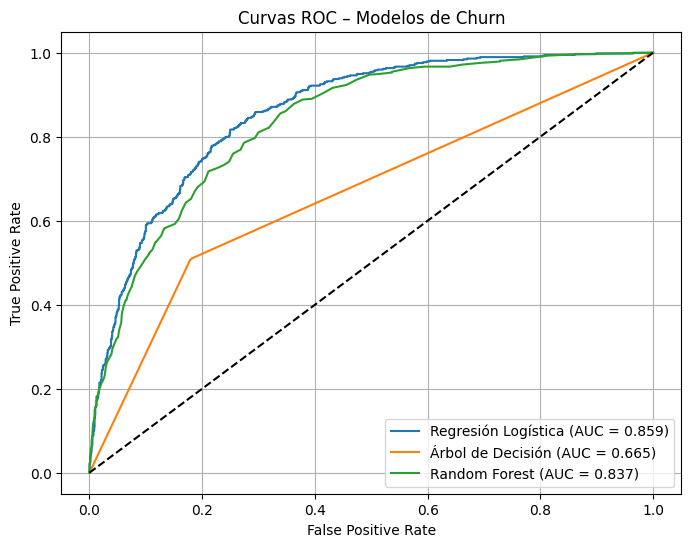

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for nombre, modelo in modelos.items():
    y_proba = modelo.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC – Modelos de Churn")
plt.legend()
plt.grid()
plt.show()


Importancia de variables (Random Forest)

El modelo de Random Forest permite identificar las características que más influyen en que un cliente abandone el servicio (churn).

Este análisis es crucial para generar conclusiones y recomendaciones de negocio.

In [8]:
importances = rf.feature_importances_
features = X.columns

fi_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values("importance", ascending=False)

fi_df.head(15)


,feature,importance
7,TotalCharges,0.196730
3,tenure,0.170846
6,MonthlyCharges,0.166855
12,InternetService_Fiber optic,0.037345
25,PaymentMethod_Electronic check,0.035900
17,Contract_Two year,0.030844
29,gender_Male,0.028868
11,OnlineSecurity_Yes,0.025999
5,PaperlessBilling,0.025938
1,Partner,0.024104


Gráfico: Variables que más explican el Churn

Este gráfico muestra visualmente las 15 variables más importantes identificadas por el modelo.
Permite comunicar de forma clara los factores que influyen en la fuga de clientes.

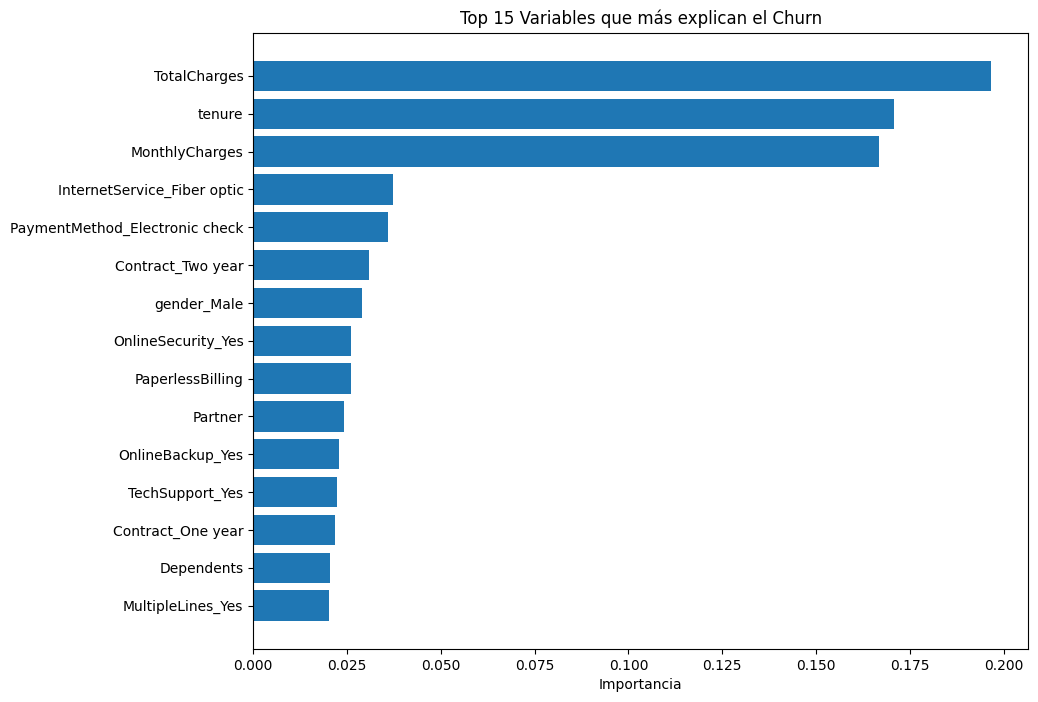

In [9]:
plt.figure(figsize=(10, 8))
plt.barh(fi_df["feature"].head(15), fi_df["importance"].head(15))
plt.gca().invert_yaxis()
plt.xlabel("Importancia")
plt.title("Top 15 Variables que más explican el Churn")
plt.show()
